In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import geodatasets
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("fraudTrain.csv")
train_df = pd.read_csv('fraudTrain.csv', index_col='Unnamed: 0')

Text(0.5, 1.0, 'Transactions by category')

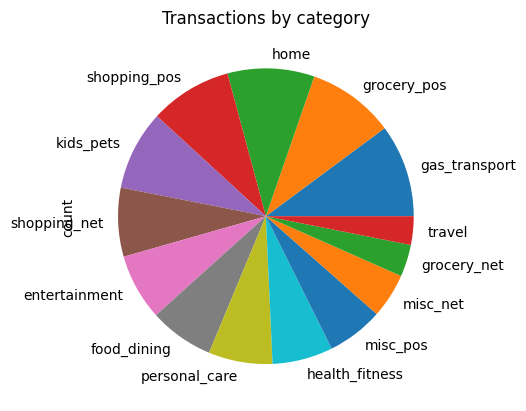

In [4]:
df['category'].value_counts().plot.pie()
plt.title("Transactions by category")

<Axes: xlabel='count', ylabel='category'>

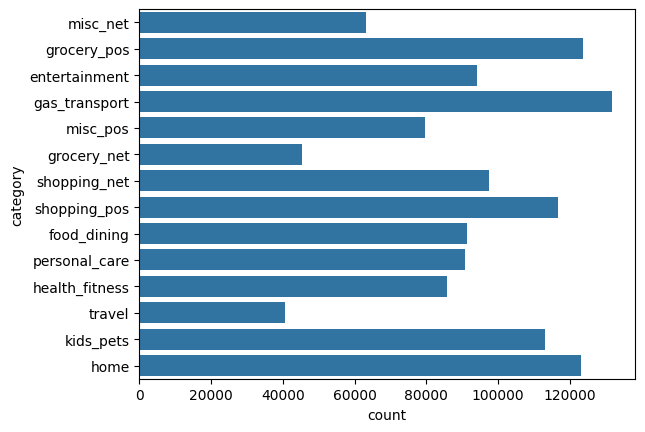

In [6]:
sns.countplot(data =df, y ="category")

Text(0.5, 0, 'Total Frauds')

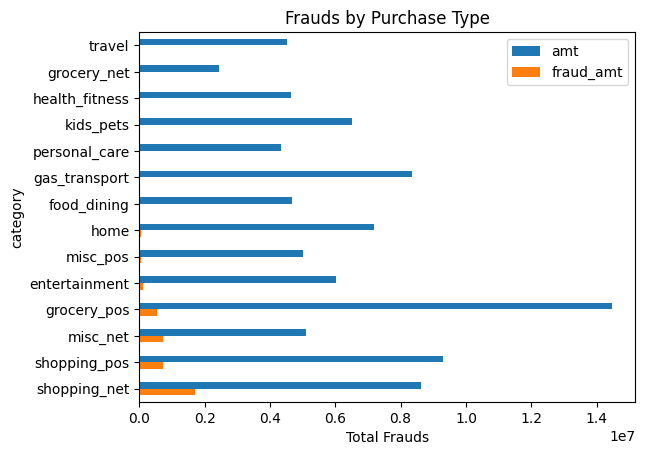

In [14]:
spend_df = df[['category', 'amt', 'is_fraud']].groupby('category').sum()
spend_df['transaction_count'] =df['category'].value_counts().values
spend_df['fraud_percentage'] = (spend_df['is_fraud']/ spend_df['transaction_count'])*100
spend_df ['fraud_amt'] = df[df['is_fraud']== 1].groupby('category')['amt'].sum()
spend_df['fraud_percentage_amount'] = (spend_df['fraud_amt']/ spend_df['amt'])*100
spend_df =spend_df.sort_values(by ='fraud_percentage_amount', ascending=False )

spend_df[['amt', 'fraud_amt']].sort_values(by='fraud_amt').plot.barh()
plt.xlabel("Total Fraud Amount")

sns.barplot(data =spend_df.sort_values(by ='is_fraud', ascending=False ),y =spend_df.index, x ='is_fraud')
plt.title('Frauds by Purchase Type')
plt.xlabel("Total Frauds")

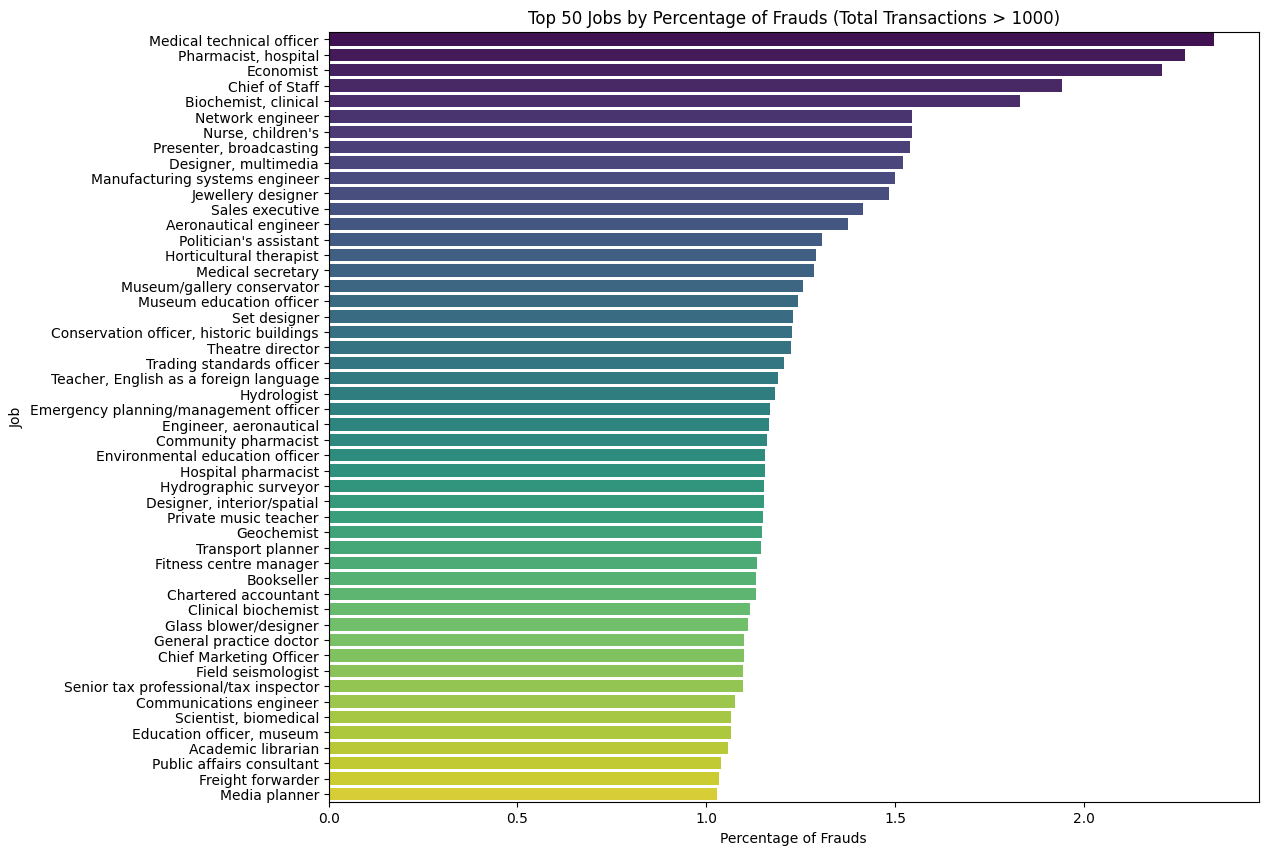

In [22]:
df['trans_date'] = pd.to_datetime(df['unix_time'], unit='s')
time_df = df.copy()
time_df['trans_date'] = df['trans_date']
time_df =time_df.sort_values(by = 'trans_date', ascending =True)

job_dict = {}

for job, group in df.groupby('job'):
    job_dict[job] = group[['trans_date', 'amt', 'is_fraud', 'category']].to_dict('records')

fraud_by_jobs = {}

for job, transactions in job_dict.items():
    aggregate = {}
    job_df = pd.DataFrame(transactions)
    
    nonFraud = job_df['is_fraud'].value_counts().get(0, 0)
    Fraud = job_df['is_fraud'].value_counts().get(1, 0)
    
    frauds_by_category = job_df[job_df['is_fraud'] == 1]['category'].value_counts().to_dict()
    percentage_frauds = (Fraud / (nonFraud + Fraud)) *100 if (nonFraud + Fraud) > 0 else 0
    
    aggregate['is_fraud'] = Fraud
    aggregate['not_fraud'] = nonFraud
    aggregate['percentage_fraud'] = percentage_frauds
    aggregate['fraud_category_composition'] = frauds_by_category
    
    fraud_by_jobs[job] = aggregate

filtered_jobs = {
    job: details for job, details in fraud_by_jobs.items()
    if details['is_fraud'] + details['not_fraud'] > 1000
}
job_percentage_fraud_df = pd.DataFrame([
    {'job': job, 'percentage_fraud': details['percentage_fraud'], 'total_transactions': details['is_fraud'] + details['not_fraud']}
    for job, details in filtered_jobs.items()
])

job_percentage_fraud_df = job_percentage_fraud_df.sort_values(by='percentage_fraud', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x='percentage_fraud', y='job', data=job_percentage_fraud_df.head(50), palette='viridis')
plt.xlabel('Percentage of Frauds')
plt.ylabel('Job')
plt.title('Top 50 Jobs by Percentage of Frauds (Total Transactions > 1000)')
plt.show()

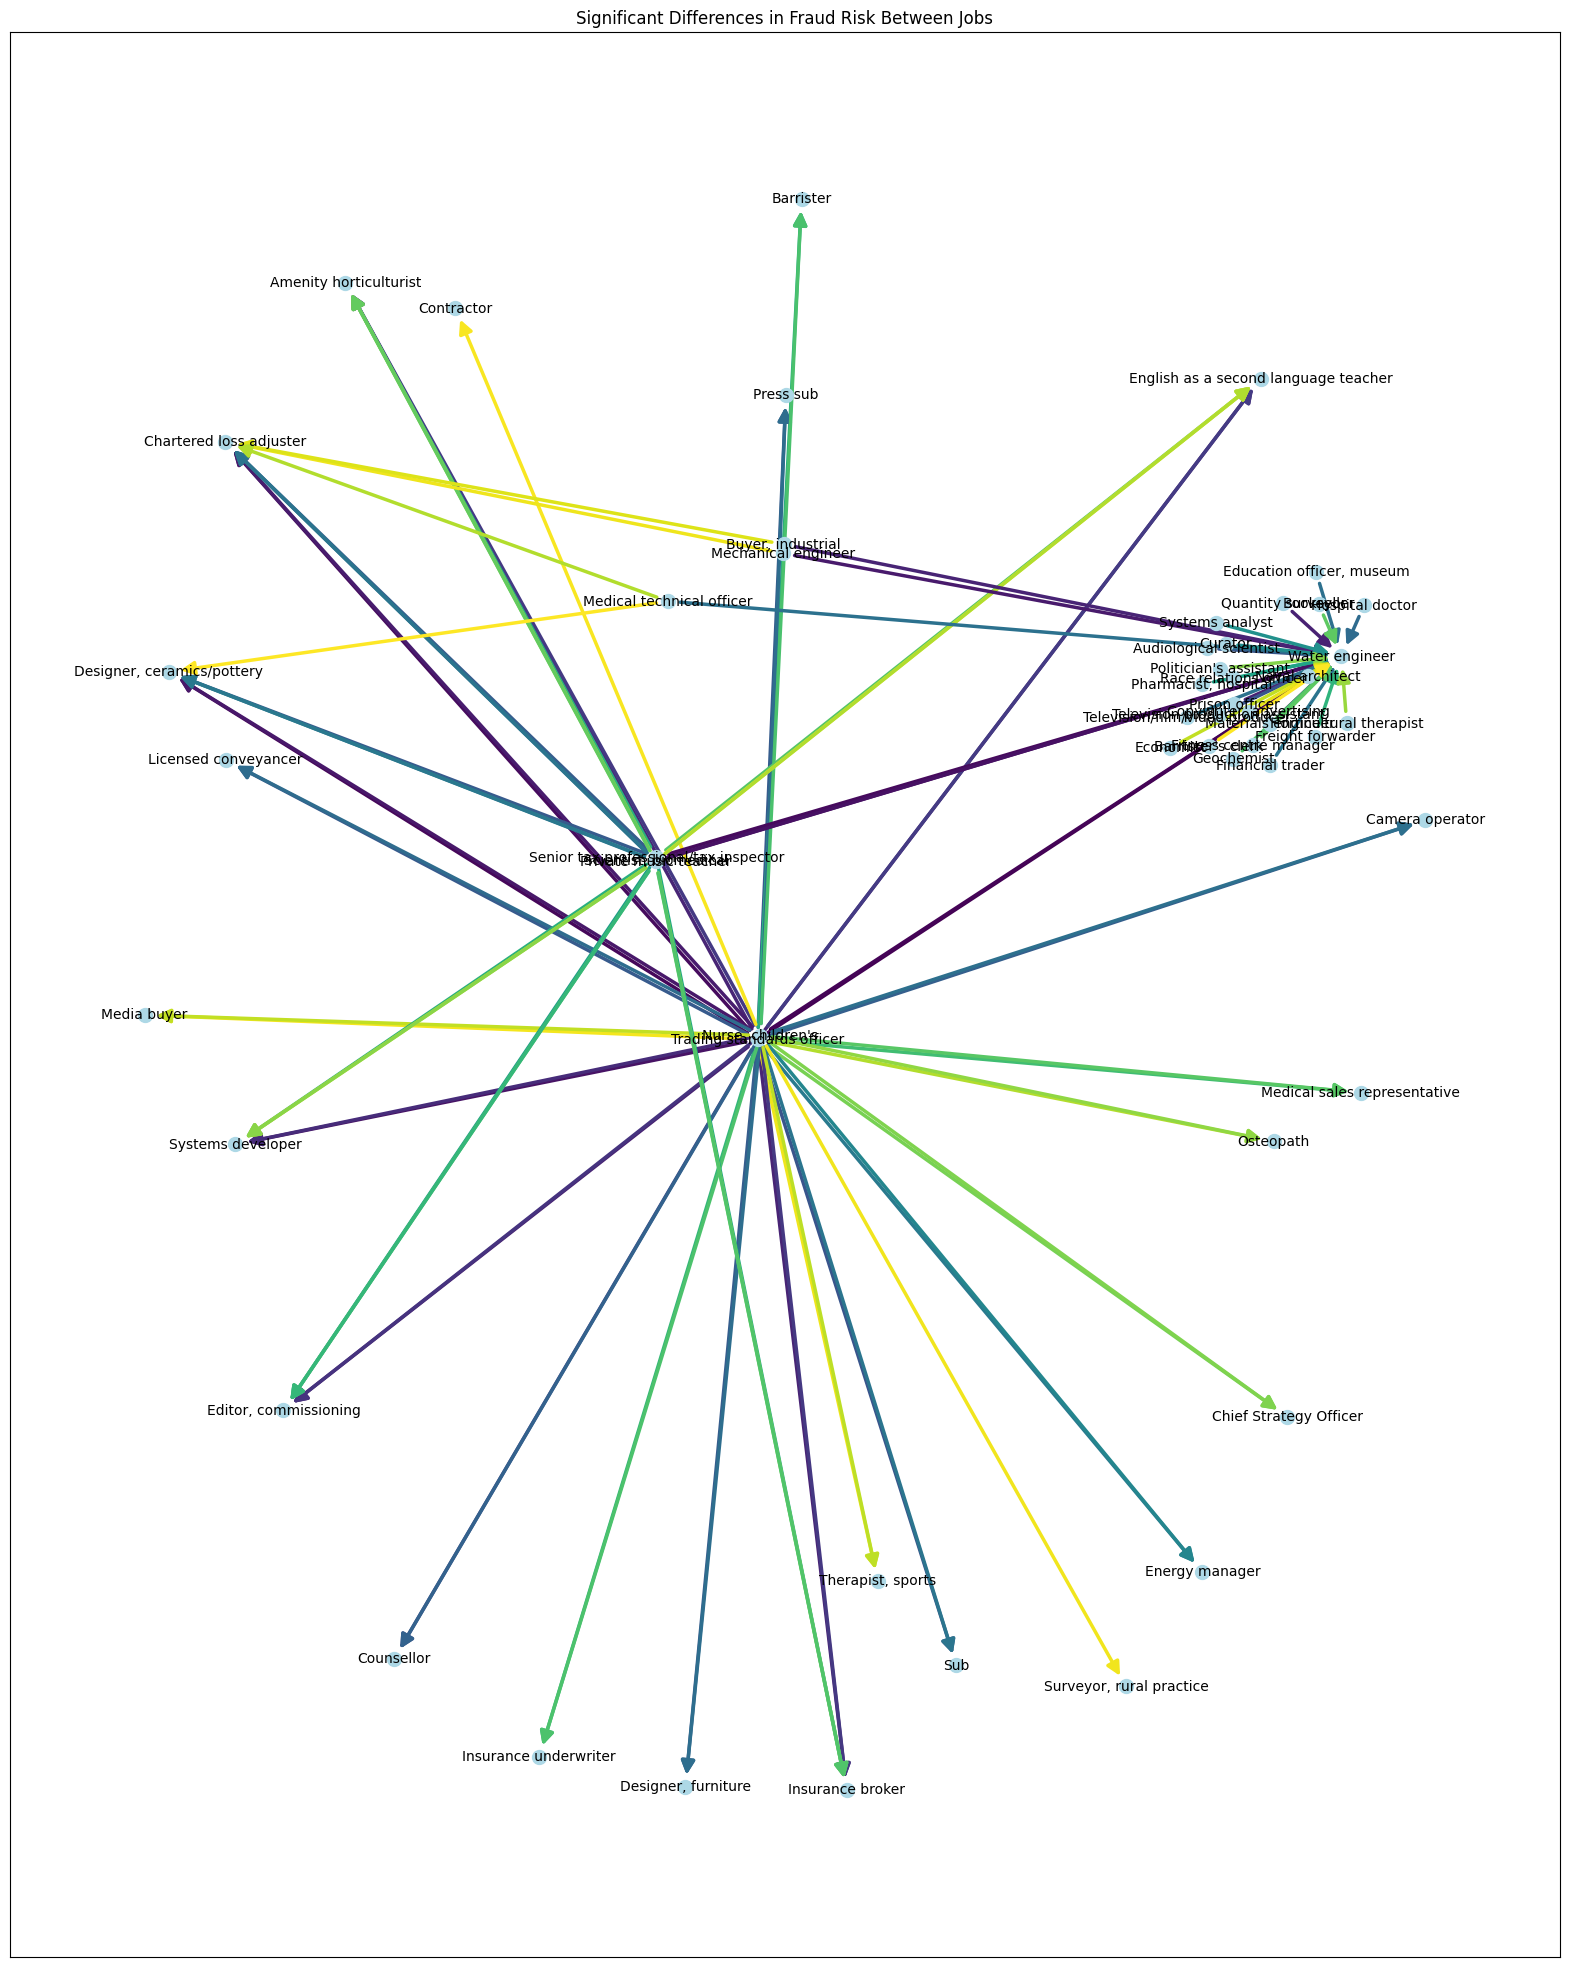

In [26]:
significant_pairs =[]
mat = np.array(job_percentage_fraud_df)
for idx1, row1 in enumerate(mat):
    for idx2, row2 in enumerate(mat):
        n1 =row1[2]
        n2 =row2[2]
        p1 = row1[1]/100
        p2 = row2[1]/100
        if(n1==0 or n2==0):
            continue
        
        p = min(p1, p2)
        p_hat = max(p1,p2)
        var  =  (p_hat)*(1-p_hat)*(1/n1 + 1/n2) + 0.0000001 ## tolerance so that values are not too small
        
        z = (p_hat -p)/ np.sqrt(var)
        p_value = 1-stats.norm.cdf(z)
        ## one tailed test
        if(p_value <0.05):
            if(p2== p_hat):
                state ={}
                state['high_risk'] =row2[0]
                state['low _risk'] =row1[0] 
                state['p_value'] =p_value
                
                significant_pairs.append(state)
            else:
                state ={}
                state['high_risk'] =row1[0]
                state['low _risk'] =row2[0]
                state['p_value'] =p_value
significant_pairs.sort(key = lambda x: x['p_value'])

import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()
for pair in significant_pairs[:100]:
    high_risk = pair['high_risk']
    low_risk = pair['low _risk']
    p_value = pair['p_value']
    G.add_edge(high_risk, low_risk, p_value=p_value)

pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(20, 25))

nx.draw_networkx_nodes(G, pos, node_size=100, node_color='lightblue')

edges = G.edges(data=True)
edge_colors = [edge[2]['p_value'] for edge in edges]
edge_widths = [50 * (0.05 - edge[2]['p_value']) for edge in edges]  # bigger width for smaller p-values

nx.draw_networkx_edges(G, pos, edgelist=edges, width=edge_widths, edge_color=edge_colors, edge_cmap=plt.cm.viridis, arrowsize=20)

nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(edge_colors), vmax=max(edge_colors)))
sm.set_array([])
# plt.colorbar(sm, label='p-value')

plt.title('Significant Differences in Fraud Risk Between Jobs')
plt.show()

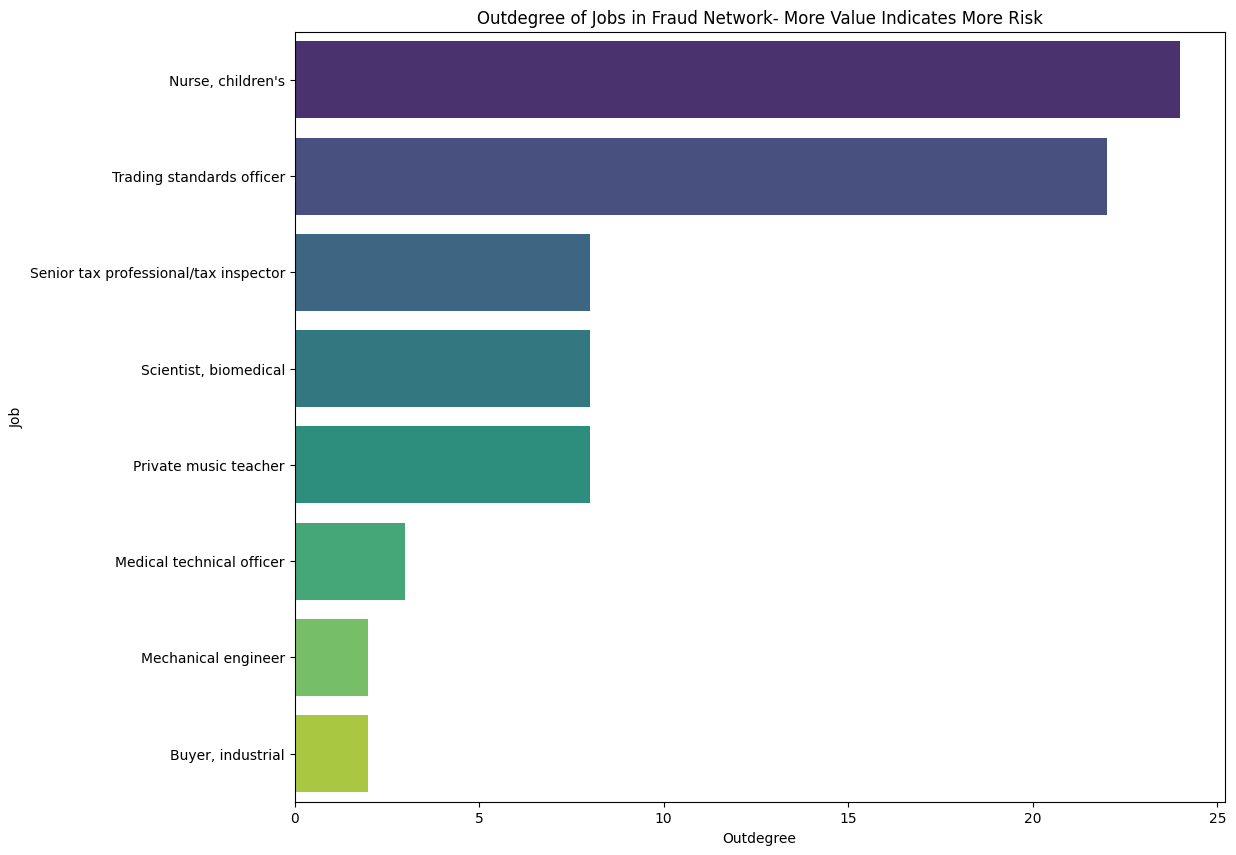

In [28]:
len(significant_pairs)
out_degree = G.out_degree()
out_degree = dict(out_degree)
out_degree =dict(sorted(out_degree.items(), key=lambda item: item[1],reverse=True))
# out_degree
df_outdegree = pd.DataFrame(list(out_degree.items()), columns=['Job', 'Outdegree'])
df_outdegree = df_outdegree.sort_values(by='Outdegree', ascending=False)

# Plot
plt.figure(figsize=(12, 10))
sns.barplot(x='Outdegree', y='Job', data=df_outdegree[:8], palette='viridis')
plt.xlabel('Outdegree')
plt.ylabel('Job')
plt.title('Outdegree of Jobs in Fraud Network- More Value Indicates More Risk')
plt.show()

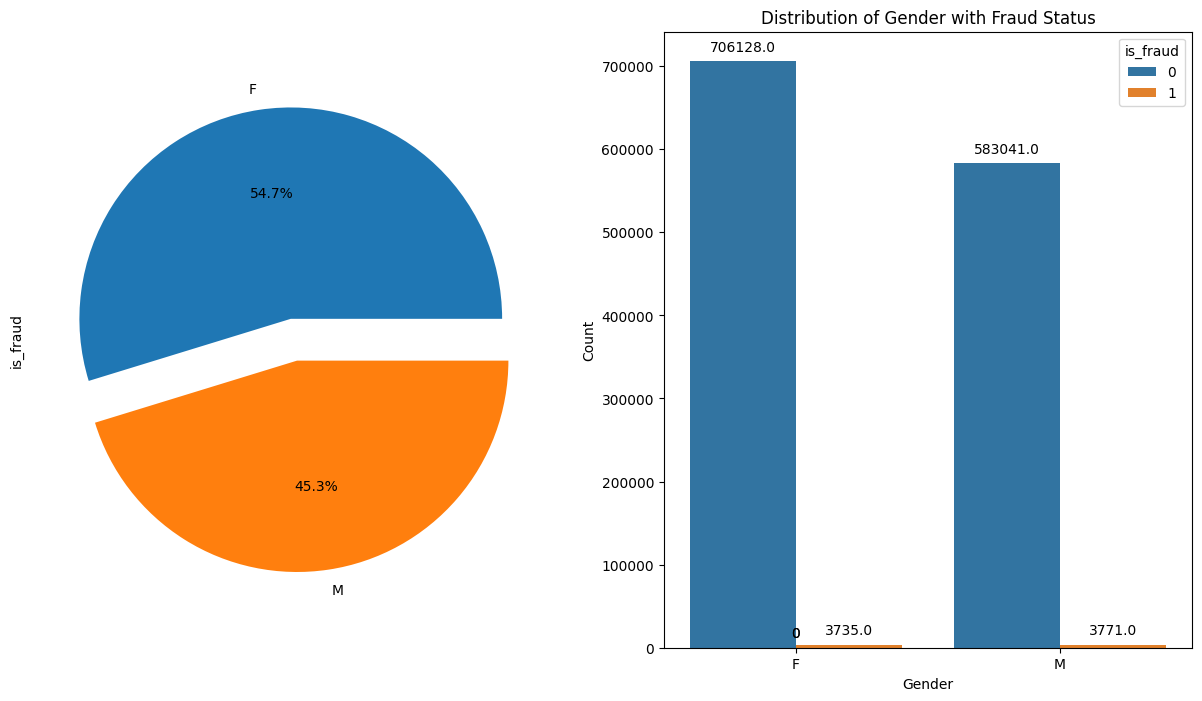

In [34]:
fig,axb = plt.subplots(ncols=2,nrows=1,figsize=(15, 8))

#Gender Distribution
explode = [0.1, 0.1]
train_df.groupby('gender')['is_fraud'].count().plot.pie(explode=explode, autopct="%1.1f%%",ax=axb[0]);

ax = sns.countplot(x="gender", hue="is_fraud", data=train_df,ax=axb[1])

# Add values on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Set labels and title
plt.title("Distribution of Gender with Fraud Status")
plt.xlabel("Gender")
plt.ylabel("Count")

# Show the plot
plt.show()

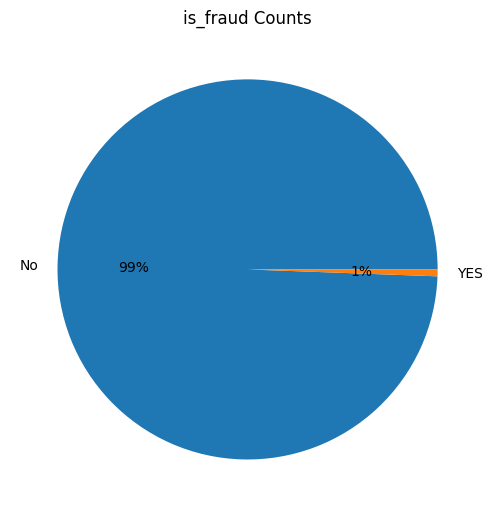

In [36]:
is_fraud = train_df["is_fraud"].value_counts()
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)  # Subplot for the pie chart
plt.pie(is_fraud, labels=["No", "YES"], autopct="%0.0f%%")
plt.title("is_fraud Counts")
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

# DATA PREPROCESSING

In [114]:
test_df = pd.read_csv("fraudTest.csv",  index_col='Unnamed: 0')
train_df = pd.read_csv('fraudTrain.csv', index_col='Unnamed: 0')

unique_transaction_count = len(train_df['trans_num'].unique())
print("Total count of unique transaction numbers:", unique_transaction_count)

columns_to_drop = ['first', 'unix_time', 'dob', 'cc_num', 'zip', 'city','street', 'state', 'trans_num', 'trans_date_trans_time']
train_df = train_df.drop(columns_to_drop, axis=1)
test_df = test_df.drop(columns_to_drop, axis=1)
train_df.head(2)

Total count of unique transaction numbers: 1296675


,merchant,category,amt,last,gender,lat,long,city_pop,job,merch_lat,merch_long,is_fraud
0,"fraud_Rippin, Kub and Mann",misc_net,4.97,Banks,F,36.0788,-81.1781,3495,"Psychologist, counselling",36.011293,-82.048315,0
1,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Gill,F,48.8878,-118.2105,149,Special educational needs teacher,49.159047,-118.186462,0


In [115]:
#clean merchant column
train_df['merchant'] = train_df['merchant'].apply(lambda x : x.replace('fraud_',''))
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296675 entries, 0 to 1296674
Data columns (total 12 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   merchant    1296675 non-null  object 
 1   category    1296675 non-null  object 
 2   amt         1296675 non-null  float64
 3   last        1296675 non-null  object 
 4   gender      1296675 non-null  object 
 5   lat         1296675 non-null  float64
 6   long        1296675 non-null  float64
 7   city_pop    1296675 non-null  int64  
 8   job         1296675 non-null  object 
 9   merch_lat   1296675 non-null  float64
 10  merch_long  1296675 non-null  float64
 11  is_fraud    1296675 non-null  int64  
dtypes: float64(5), int64(2), object(5)
memory usage: 128.6+ MB


In [122]:
train_df.describe(include='object')

,merchant,category,last,gender,job
count,1296675,1296675,1296675,1296675,1296675
unique,693,14,481,2,494
top,Kilback LLC,gas_transport,Smith,F,Film/video editor
freq,4403,131659,28794,709863,9779


In [124]:
from category_encoders.woe import WOEEncoder


# applying label encoding
train_df['gender'] = train_df['gender'].map({'F': 0, 'M': 1})

# applying WOE encoding
for col in ['job','merchant', 'category', 'lat', 'last']:
    train_df[col] = WOEEncoder().fit_transform(train_df[col],train_df['is_fraud'])

train_df.head(3)

,merchant,category,amt,last,gender,lat,long,city_pop,job,merch_lat,merch_long,is_fraud
0,0.959326,0.924914,4.97,-2.469513,0,36.0788,-81.1781,3495,-1.080186,36.011293,-82.048315,0
1,0.663187,0.898799,107.23,-0.673638,0,48.8878,-118.2105,149,-0.904144,49.159047,-118.186462,0
2,-0.790166,-0.847622,220.11,0.433257,1,42.1808,-112.2620,4154,1.120434,43.150704,-112.154481,0


## Down sampling and sacling

In [120]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

No_class = train_df[train_df["is_fraud"]==0]
yes_class = train_df[train_df["is_fraud"]==1]

No_class = resample(No_class, replace=False, n_samples=len(yes_class))
down_samples = pd.concat([yes_class, No_class], axis=0)


X = down_samples.drop("is_fraud", axis=1)
y = down_samples["is_fraud"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=65)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Count the occurrences of each class in the original dataset
original_class_counts = train_df["is_fraud"].value_counts()

# Count the occurrences of each class in the downsampled dataset
downsampled_class_counts = down_samples["is_fraud"].value_counts()

# Calculate the percentage of each class
original_percentages = original_class_counts / len(train_df) * 100
downsampled_percentages = downsampled_class_counts / len(down_samples) * 100

# Plotting
plt.figure(figsize=(12, 6))

# Bar chart for original class distribution
plt.subplot(1, 2, 1)
bars_1 = plt.bar(original_class_counts.index, original_class_counts.values, color=['orange', 'green'])
for bar, label in zip(bars_1, original_percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, f'{label:.2f}%', ha='center', va='bottom')
plt.title('Original Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(original_class_counts.index, ['No Fraud', 'Fraud'])

# Bar chart for downsampled class distribution
plt.subplot(1, 2, 2)
bars_2 = plt.bar(downsampled_class_counts.index, downsampled_class_counts.values, color=['orange', 'green'])
for bar, label in zip(bars_2, downsampled_percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, f'{label:.2f}%', ha='center', va='bottom')
plt.title('Downsampled Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(downsampled_class_counts.index, ['No Fraud', 'Fraud'])

plt.tight_layout() # the plots will be automatically adjusted to ensure that there is no overlap between subplots and that all elements are clearly visible.
plt.show()

ValueError: could not convert string to float: 'Okuneva, Schneider and Rau'

In [128]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import joblib
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Load data
train_df = pd.read_csv('fraudTrain.csv', index_col='Unnamed: 0')
test_df = pd.read_csv('fraudTest.csv', index_col='Unnamed: 0')

# Drop unnecessary columns
columns_to_drop = ['first', 'unix_time', 'dob', 'cc_num', 'zip', 'city','street', 'state', 'trans_num', 'trans_date_trans_time']
train_df = train_df.drop(columns_to_drop, axis=1)
test_df = test_df.drop(columns_to_drop, axis=1)

# Apply label encoding to 'gender' column
train_df['gender'] = train_df['gender'].map({'F': 0, 'M': 1})

# Apply WOE encoding
from category_encoders.woe import WOEEncoder
for col in ['job', 'merchant', 'category', 'lat', 'last']:
    train_df[col] = WOEEncoder().fit_transform(train_df[col], train_df['is_fraud'])

# Check for NaN values in 'merchant' column
train_df['merchant'] = train_df['merchant'].fillna('')  # Fill NaN values with an empty string

# Clean 'merchant' column by removing 'fraud_' prefix
train_df['merchant'] = train_df['merchant'].apply(lambda x: x.replace('fraud_', '') if isinstance(x, str) else x)



# Resampling: downsample majority class
No_class = train_df[train_df["is_fraud"] == 0]
yes_class = train_df[train_df["is_fraud"] == 1]
No_class = resample(No_class, replace=False, n_samples=len(yes_class))
down_samples = pd.concat([yes_class, No_class], axis=0)

# Prepare features and target
X = down_samples.drop("is_fraud", axis=1)
y = down_samples["is_fraud"]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=65)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Choose the model: Logistic Regression or XGBoost
# Option 1: Logistic Regression
log_reg_model = LogisticRegression(random_state=42)
log_reg_model.fit(X_train, y_train)

# Option 2: XGBoost (Uncomment to use XGBoost)
# xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
# xgb_model.fit(X_train, y_train)

# Save the model for Flask deployment
joblib.dump(log_reg_model, 'fraud_detection_model.pkl')  # Save Logistic Regression model
# joblib.dump(xgb_model, 'fraud_detection_model_xgb.pkl')  # Save XGBoost model (if chosen)

# Evaluate the model on the test set
from sklearn.metrics import classification_report, accuracy_score
log_reg_predictions = log_reg_model.predict(X_test)
log_reg_confidence = log_reg_model.predict_proba(X_test)[:, 1]  # Positive class confidence

# XGBoost Evaluation (if chosen)
# xgb_predictions = xgb_model.predict(X_test)
# xgb_confidence = xgb_model.predict_proba(X_test)[:, 1]

# Print evaluation metrics
print("Logistic Regression Classification Report:")
print(classification_report(y_test, log_reg_predictions))
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, log_reg_predictions) * 100:.2f}%")

# Select a random sample from the test set
random_index = np.random.randint(0, X_test.shape[0])
random_sample = X_test[random_index].reshape(1, -1)

# Logistic Regression Prediction and Confidence
log_reg_prediction = log_reg_model.predict(random_sample)[0]
log_reg_conf_score = log_reg_model.predict_proba(random_sample)[0][1]

# XGBoost Prediction and Confidence (if chosen)
# xgb_prediction = xgb_model.predict(random_sample)[0]
# xgb_conf_score = xgb_model.predict_proba(random_sample)[0][1]

# Display Results for the Random Sample
print("\n### Random Sample Evaluation ###")
print(f"Actual Label: {'Fraud' if y_test.iloc[random_index] == 1 else 'Not Fraud'}")
print(f"Logistic Regression Prediction: {'Fraud' if log_reg_prediction == 1 else 'Not Fraud'}, Confidence Score: {log_reg_conf_score:.2f}")
# print(f"XGBoost Prediction: {'Fraud' if xgb_prediction == 1 else 'Not Fraud'}, Confidence Score: {xgb_conf_score:.2f}")


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.93      0.86      1486
           1       0.92      0.77      0.84      1517

    accuracy                           0.85      3003
   macro avg       0.86      0.85      0.85      3003
weighted avg       0.86      0.85      0.85      3003

Logistic Regression Accuracy: 84.88%

### Random Sample Evaluation ###
Actual Label: Fraud
Logistic Regression Prediction: Fraud, Confidence Score: 0.69


In [130]:
random_index = np.random.randint(0, X_test.shape[0])
random_sample = X_test[random_index].reshape(1, -1)

# Logistic Regression Prediction and Confidence
log_reg_prediction = log_reg_model.predict(random_sample)[0]
log_reg_conf_score = log_reg_model.predict_proba(random_sample)[0][1]

# XGBoost Prediction and Confidence (if chosen)
# xgb_prediction = xgb_model.predict(random_sample)[0]
# xgb_conf_score = xgb_model.predict_proba(random_sample)[0][1]

# Display Results for the Random Sample
print("\n### Random Sample Evaluation ###")
print(f"Actual Label: {'Fraud' if y_test.iloc[random_index] == 1 else 'Not Fraud'}")
print(f"Logistic Regression Prediction: {'Fraud' if log_reg_prediction == 1 else 'Not Fraud'}, Confidence Score: {log_reg_conf_score:.2f}")
# print(f"XGBoost Prediction: {'Fraud' if xgb_prediction == 1 else 'Not Fraud'}, Confidence Score: {xgb_conf_score:.2f}")



### Random Sample Evaluation ###
Actual Label: Not Fraud
Logistic Regression Prediction: Fraud, Confidence Score: 1.00


In [132]:
random_index = np.random.randint(0, X_test.shape[0])
random_sample = X_test[random_index].reshape(1, -1)

# Logistic Regression Prediction and Confidence
log_reg_prediction = log_reg_model.predict(random_sample)[0]
log_reg_conf_score = log_reg_model.predict_proba(random_sample)[0][1]

# XGBoost Prediction and Confidence (if chosen)
# xgb_prediction = xgb_model.predict(random_sample)[0]
# xgb_conf_score = xgb_model.predict_proba(random_sample)[0][1]

# Display Results for the Random Sample
print("\n### Random Sample Evaluation ###")
print(f"Actual Label: {'Fraud' if y_test.iloc[random_index] == 1 else 'Not Fraud'}")
print(f"Logistic Regression Prediction: {'Fraud' if log_reg_prediction == 1 else 'Not Fraud'}, Confidence Score: {log_reg_conf_score:.2f}")
# print(f"XGBoost Prediction: {'Fraud' if xgb_prediction == 1 else 'Not Fraud'}, Confidence Score: {xgb_conf_score:.2f}")



### Random Sample Evaluation ###
Actual Label: Not Fraud
Logistic Regression Prediction: Not Fraud, Confidence Score: 0.18


In [134]:
random_index = np.random.randint(0, X_test.shape[0])
random_sample = X_test[random_index].reshape(1, -1)

# Logistic Regression Prediction and Confidence
log_reg_prediction = log_reg_model.predict(random_sample)[0]
log_reg_conf_score = log_reg_model.predict_proba(random_sample)[0][1]

# XGBoost Prediction and Confidence (if chosen)
# xgb_prediction = xgb_model.predict(random_sample)[0]
# xgb_conf_score = xgb_model.predict_proba(random_sample)[0][1]

# Display Results for the Random Sample
print("\n### Random Sample Evaluation ###")
print(f"Actual Label: {'Fraud' if y_test.iloc[random_index] == 1 else 'Not Fraud'}")
print(f"Logistic Regression Prediction: {'Fraud' if log_reg_prediction == 1 else 'Not Fraud'}, Confidence Score: {log_reg_conf_score:.2f}")
# print(f"XGBoost Prediction: {'Fraud' if xgb_prediction == 1 else 'Not Fraud'}, Confidence Score: {xgb_conf_score:.2f}")



### Random Sample Evaluation ###
Actual Label: Fraud
Logistic Regression Prediction: Not Fraud, Confidence Score: 0.20


In [136]:
random_index = np.random.randint(0, X_test.shape[0])
random_sample = X_test[random_index].reshape(1, -1)

# Logistic Regression Prediction and Confidence
log_reg_prediction = log_reg_model.predict(random_sample)[0]
log_reg_conf_score = log_reg_model.predict_proba(random_sample)[0][1]

# XGBoost Prediction and Confidence (if chosen)
# xgb_prediction = xgb_model.predict(random_sample)[0]
# xgb_conf_score = xgb_model.predict_proba(random_sample)[0][1]

# Display Results for the Random Sample
print("\n### Random Sample Evaluation ###")
print(f"Actual Label: {'Fraud' if y_test.iloc[random_index] == 1 else 'Not Fraud'}")
print(f"Logistic Regression Prediction: {'Fraud' if log_reg_prediction == 1 else 'Not Fraud'}, Confidence Score: {log_reg_conf_score:.2f}")
# print(f"XGBoost Prediction: {'Fraud' if xgb_prediction == 1 else 'Not Fraud'}, Confidence Score: {xgb_conf_score:.2f}")



### Random Sample Evaluation ###
Actual Label: Fraud
Logistic Regression Prediction: Fraud, Confidence Score: 0.99


In [138]:
random_index = np.random.randint(0, X_test.shape[0])
random_sample = X_test[random_index].reshape(1, -1)

# Logistic Regression Prediction and Confidence
log_reg_prediction = log_reg_model.predict(random_sample)[0]
log_reg_conf_score = log_reg_model.predict_proba(random_sample)[0][1]

# XGBoost Prediction and Confidence (if chosen)
# xgb_prediction = xgb_model.predict(random_sample)[0]
# xgb_conf_score = xgb_model.predict_proba(random_sample)[0][1]

# Display Results for the Random Sample
print("\n### Random Sample Evaluation ###")
print(f"Actual Label: {'Fraud' if y_test.iloc[random_index] == 1 else 'Not Fraud'}")
print(f"Logistic Regression Prediction: {'Fraud' if log_reg_prediction == 1 else 'Not Fraud'}, Confidence Score: {log_reg_conf_score:.2f}")
# print(f"XGBoost Prediction: {'Fraud' if xgb_prediction == 1 else 'Not Fraud'}, Confidence Score: {xgb_conf_score:.2f}")



### Random Sample Evaluation ###
Actual Label: Fraud
Logistic Regression Prediction: Fraud, Confidence Score: 1.00
